# Implémentation UNet

## Importation des bibliothèques

In [20]:
# === Base Python ===
import os
import glob
import random
from pathlib import Path

# === Typage ===
from typing import Optional, Union, Tuple

# === NumPy / Pandas / Math / Visualisation ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

# === PIL (images) ===
from PIL import Image

# === PyTorch / Torchvision ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torchvision
from torchvision import transforms

# === Monai (medical imaging) ===
import monai
from monai.transforms import LoadImage
from monai.losses import DiceLoss

# === Affichage modèle ===
from torchinfo import summary

# === Barre de progression ===
from tqdm.auto import tqdm


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

Using device: cuda
2.5.1
12.4
True


## Load PNG Data

In [ ]:
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import os
import re

class PngSlicesDataset(Dataset):
    def __init__(self, root_dir, resized_width=256, resized_height=256, slice_range=None, transform=None):
        self.image_paths = []
        self.mask_paths = []
        self.resized_width = resized_width
        self.resized_height = resized_height
        self.slice_range = slice_range
        self.transform = transform if transform is not None else transforms.ToTensor()

        patients = os.listdir(root_dir)
        for patient in patients:
            images_folder = os.path.join(root_dir, patient, "IRM")
            masks_folder = os.path.join(root_dir, patient, "masque")

            if not os.path.isdir(images_folder) or not os.path.isdir(masks_folder):
                continue

            image_files = sorted(os.listdir(images_folder))

            for img_file in image_files:
                # Utiliser une expression régulière pour détecter slice_XXXX.png
                match = re.match(r"slice_(\d+)\.png", img_file)
                if not match:
                    continue  # Si ce n'est pas un slice_XXXX.png, on ignore

                slice_num = int(match.group(1))

                if self.slice_range:
                    if not (self.slice_range[0] <= slice_num <= self.slice_range[1]):
                        continue

                img_path = os.path.join(images_folder, img_file)
                mask_path = os.path.join(masks_folder, img_file)

                if os.path.exists(img_path) and os.path.exists(mask_path):
                    self.image_paths.append(img_path)
                    self.mask_paths.append(mask_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('L')
        mask = Image.open(self.mask_paths[idx]).convert('L')

        resize_transform = transforms.Resize((self.resized_height, self.resized_width))

        img = resize_transform(img)
        mask = resize_transform(mask)

        img = self.transform(img)
        mask = self.transform(mask)

        img = (img - 0.5) / 0.5  # Normaliser [-1,1]
        mask = (mask > 0.5).float()  # Binariser

        return img, mask, os.path.basename(self.image_paths[idx])


## Define train, test, validation dataset

### Here we get the initial image shapes

This value is important, as it will allow us to resize our entire dataset. We must also bear in mind that the size **must be a multiple of two**. This is because, through downsampling (by a factor of two), **we want natural numbers**. 

In [ ]:
from PIL import Image
import os

def GetInitialImageShape(images_folder): 
    image_files = sorted([f for f in os.listdir(images_folder) if f.endswith('.png')])
    img = Image.open(os.path.join(images_folder, image_files[0]))
    w, h = img.size
    return (w,h)

def getNearestMultipleOfTwo(x):
    multipleOfTwo = [2**i for i in range(10)]
    mini = float('inf')
    nearest_value = None
    
    for elem in multipleOfTwo:
        difference = abs(elem - x)
        if difference < mini:
            mini = difference
            nearest_value = elem
    
    return nearest_value

Here we define `width` and `height` of our __dataset__ et autres constantes

In [28]:
w,h = GetInitialImageShape("./UNet_data_png/01016SACH/IRM")
width = getNearestMultipleOfTwo(w)
height = getNearestMultipleOfTwo(h)
slice_range = [145, 291]
LEARNING_RATE = 3e-4
BATCH_SIZE = 8
learning_rate = 0.001
n_epochs = 120
ROOT_DIR = './UNet_data_png'

In [29]:
dataset = PngSlicesDataset(
    root_dir=ROOT_DIR,
    resized_width=width,
    resized_height=height,
    slice_range=slice_range
)

num_samples = len(dataset)
indices = np.random.RandomState(seed=25).permutation(num_samples)

train_size = int(0.8 * num_samples)
test_size = int(0.1 * num_samples)
val_size = num_samples - train_size - test_size

train_idx = indices[:train_size]
test_idx = indices[train_size:train_size + test_size]
val_idx = indices[train_size + test_size:]

train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)
val_dataset = Subset(dataset, val_idx)


### Data loader + his test


In [30]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset,batch_size=BATCH_SIZE,shuffle= False)
test_dataloader = DataLoader(dataset=test_dataset,batch_size=1, shuffle=False)

In [31]:
# Vérification du DataLoader
for img, mask, path in  test_dataloader:
    print(f'Image batch shape: {img.shape}')
    print(f'Mask batch shape: {mask.shape}')
    print(f'Image path: {path[0]}')  # Afficher un chemin d'image pour vérifier
    break  # Juste pour vérifier une première itération

Image batch shape: torch.Size([1, 1, 256, 256])
Mask batch shape: torch.Size([1, 1, 256, 256])
Image path: slice_238.png


## Visualize data samples

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Obtenir un index aléatoire pour chaque dataset
train_idx = np.random.randint(len(train_dataset))
val_idx = np.random.randint(len(val_dataset))
test_idx = np.random.randint(len(test_dataset))

print("train_idx:", train_idx)
print("val_idx:", val_idx)
print("test_idx:", test_idx)

def plot_slice(dataset, index, dataset_name):
    batch_data = dataset[index]
    image, label = batch_data[0].to(device), batch_data[1].to(device)

    # Conversion en numpy
    image = image.squeeze().detach().cpu().numpy()
    label = label.squeeze().detach().cpu().numpy()

    image = (image + 1) / 2.0  # Normaliser [0,1]

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    axes[0].imshow(image, cmap='gray')
    axes[0].set_title(f"{dataset_name} - Image")
    axes[0].axis('off')

    axes[1].imshow(image, cmap='gray')
    axes[1].imshow(label, cmap='Reds', alpha=0.4)
    axes[1].set_title(f"{dataset_name} - Overlay")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

# 🔥 Afficher séparément
plot_slice(train_dataset, train_idx, dataset_name="Training")
#plot_slice(val_dataset, val_idx, dataset_name="Validation")
#plot_slice(test_dataset, test_idx, dataset_name="Test")


## UNet Network Architecture

#### UNet params

In [32]:
# Model Architecture Parameters
input_channels = 1
num_classes  = 1      #  e.g. 1 for binary segmentation (background vs object)
input_shape = (input_channels, width, height)  # This is the shape of the input image to the network
output_shape = (num_classes, width, height)  # This is the shape of the output mask
init_channels = 32              # This is the number of channels in the first layer of the network
model_weights_path = "model_unet_no_data_traitement_120.pth"

#### The UNet model 

In [33]:
from monai.networks.nets import UNet

# Define a Unet with  monai, lighter than Class Unet 
# Creation of the model U-Net with MONAI
model = UNet(
    spatial_dims = 2,                   # 2D U-Net
    in_channels = 1,                    # e.g. 3 for RGB, 1 for grayscale input images
    out_channels = 1,                   # 1 for binary segmentation
    channels = (16, 32, 64, 128, 256),  # Nombres de canaux aux différents niveaux d'encodage
    strides = (2, 2, 2, 2),             # Strides de downsampling (modèle aura 4 niveaux) 
    num_res_units=1                     # Nombre d'unités résiduelles par bloc
).to(device)


#### Loss functions

In [34]:
# Option 1 : Utiliser Dice Loss seule => pas tres performant
# criterion = DiceLoss(sigmoid=True)

# Option 2 (recommandée) : Combiner Dice + BCE
class ComboLoss(nn.Module):
    def __init__(self, dice_weight=0.7):
        super().__init__()
        self.dice = DiceLoss(sigmoid=True)
        self.bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([20.0]).to(device))  # 20 peut être ajusté
        self.dice_weight = dice_weight

    def forward(self, inputs, targets):
        dice_loss = self.dice(inputs, targets)
        bce_loss = self.bce(inputs, targets)
        return self.dice_weight * dice_loss + (1 - self.dice_weight) * bce_loss

criterion = ComboLoss(dice_weight=0.7)

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

### Function to train the model

In [43]:
def train_model(model, train_dataloader, val_dataloader, optimizer, criterion, device, n_epochs, min_epoch=10):
    import torch
    from tqdm import tqdm

    model = model.to(device)
    train_losses = []
    valid_losses = []

    best_diff = float('inf')
    best_model_state = None
    best_epoch = 0

    for epoch in range(n_epochs):
        model.train()
        train_loss = 0.0

        for batch_data in tqdm(train_dataloader, desc=f"Epoch {epoch+1} - Training", leave=False):
            images, labels = batch_data[0].to(device), batch_data[1].to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)

        train_loss /= len(train_dataloader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for batch_data in tqdm(val_dataloader, desc=f"Epoch {epoch+1} - Validation", leave=False):
                val_inputs, val_labels = batch_data[0].to(device), batch_data[1].to(device)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                valid_loss += val_loss.item() * val_inputs.size(0)

        valid_loss /= len(val_dataloader.dataset)
        valid_losses.append(valid_loss)

        diff = abs(valid_loss - train_loss)
        print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {valid_loss:.4f} | Diff: {diff:.4f}")

        # Cherche le minimum de différence à partir de min_epoch
        if epoch + 1 >= min_epoch and diff < best_diff:
            best_diff = diff
            best_model_state = model.state_dict()
            best_epoch = epoch + 1

    print(f"\n✅ Best model selected at epoch {best_epoch} (after epoch {min_epoch}) with |Train - Val| loss diff: {best_diff:.4f}")
    
    return best_model_state, train_losses, valid_losses, best_epoch


### We save the model

In [44]:
def SaveModel(best_model, model_path, best_epoch):
    model.load_state_dict(best_model)
    torch.save(best_model, model_path)
    print(f"Best model selected at epoch {best_epoch} with validation loss: {best_valid_loss:.4f}")

def SaveTrainAndValidLosses(csv_path):
    loss_df = pd.DataFrame({
        'epoch': list(range(1, len(train_losses) + 1)),
        'train_loss': train_losses,
        'valid_loss': valid_losses
    })
    loss_df.to_csv(csv_path, index=False)
    print(f"📁 Losses saved to '{csv_path}'")

### Train and Save

In [46]:
best_model_state, train_losses, valid_losses, best_epoch = train_model(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    n_epochs=n_epochs,
    min_epoch=50
)

SaveModel(best_model_state, model_weights_path, best_epoch)


Epoch 1/120 | Train Loss: 0.8060 | Val Loss: 0.8057 | Diff: 0.0004


Epoch 2/120 | Train Loss: 0.7979 | Val Loss: 0.7968 | Diff: 0.0011


Epoch 3/120 | Train Loss: 0.7867 | Val Loss: 0.7791 | Diff: 0.0076


Epoch 4/120 | Train Loss: 0.7548 | Val Loss: 0.7388 | Diff: 0.0160


Epoch 5/120 | Train Loss: 0.7174 | Val Loss: 0.7066 | Diff: 0.0108


Epoch 6/120 | Train Loss: 0.6850 | Val Loss: 0.6776 | Diff: 0.0075


Epoch 7/120 | Train Loss: 0.6551 | Val Loss: 0.6497 | Diff: 0.0054


Epoch 8/120 | Train Loss: 0.6221 | Val Loss: 0.6198 | Diff: 0.0023


Epoch 9/120 | Train Loss: 0.5842 | Val Loss: 0.5844 | Diff: 0.0002


Epoch 10/120 | Train Loss: 0.5414 | Val Loss: 0.5498 | Diff: 0.0084


Epoch 11/120 | Train Loss: 0.4941 | Val Loss: 0.5038 | Diff: 0.0097


Epoch 12/120 | Train Loss: 0.4440 | Val Loss: 0.4673 | Diff: 0.0234


Epoch 13/120 | Train Loss: 0.4085 | Val Loss: 0.4390 | Diff: 0.0304


Epoch 14/120 | Train Loss: 0.3761 | Val Loss: 0.4189 | Diff: 0.0428


Epoch 15/120 | Train Loss: 0.3572 | Val Loss: 0.4160 | Diff: 0.0588


Epoch 16/120 | Train Loss: 0.3372 | Val Loss: 0.3821 | Diff: 0.0450


Epoch 17/120 | Train Loss: 0.3194 | Val Loss: 0.3714 | Diff: 0.0520


Epoch 18/120 | Train Loss: 0.3122 | Val Loss: 0.3681 | Diff: 0.0558


Epoch 19/120 | Train Loss: 0.3051 | Val Loss: 0.3591 | Diff: 0.0540


Epoch 20/120 | Train Loss: 0.2997 | Val Loss: 0.3578 | Diff: 0.0581


Epoch 21/120 | Train Loss: 0.2964 | Val Loss: 0.3654 | Diff: 0.0690


Epoch 22/120 | Train Loss: 0.3035 | Val Loss: 0.3735 | Diff: 0.0700


Epoch 23/120 | Train Loss: 0.2964 | Val Loss: 0.3633 | Diff: 0.0669


Epoch 24/120 | Train Loss: 0.2885 | Val Loss: 0.3632 | Diff: 0.0747


Epoch 25/120 | Train Loss: 0.2877 | Val Loss: 0.3599 | Diff: 0.0722


Epoch 26/120 | Train Loss: 0.2844 | Val Loss: 0.3748 | Diff: 0.0904


Epoch 27/120 | Train Loss: 0.2834 | Val Loss: 0.3565 | Diff: 0.0731


Epoch 28/120 | Train Loss: 0.2806 | Val Loss: 0.3560 | Diff: 0.0753


Epoch 29/120 | Train Loss: 0.2799 | Val Loss: 0.3535 | Diff: 0.0736


Epoch 30/120 | Train Loss: 0.2771 | Val Loss: 0.3558 | Diff: 0.0787


Epoch 31/120 | Train Loss: 0.2782 | Val Loss: 0.3551 | Diff: 0.0769


Epoch 32/120 | Train Loss: 0.2761 | Val Loss: 0.3593 | Diff: 0.0832


Epoch 33/120 | Train Loss: 0.2733 | Val Loss: 0.3543 | Diff: 0.0810


Epoch 34/120 | Train Loss: 0.2727 | Val Loss: 0.3519 | Diff: 0.0792


Epoch 35/120 | Train Loss: 0.2752 | Val Loss: 0.3637 | Diff: 0.0885


Epoch 36/120 | Train Loss: 0.2871 | Val Loss: 0.3842 | Diff: 0.0971


Epoch 37/120 | Train Loss: 0.2761 | Val Loss: 0.3617 | Diff: 0.0856


Epoch 38/120 | Train Loss: 0.2697 | Val Loss: 0.3574 | Diff: 0.0877


Epoch 39/120 | Train Loss: 0.2680 | Val Loss: 0.3551 | Diff: 0.0872


Epoch 40/120 | Train Loss: 0.2715 | Val Loss: 0.3588 | Diff: 0.0873


Epoch 41/120 | Train Loss: 0.2669 | Val Loss: 0.3498 | Diff: 0.0829


Epoch 42/120 | Train Loss: 0.2640 | Val Loss: 0.3544 | Diff: 0.0904


Epoch 43/120 | Train Loss: 0.2705 | Val Loss: 0.3662 | Diff: 0.0957


Epoch 44/120 | Train Loss: 0.2683 | Val Loss: 0.3738 | Diff: 0.1054


Epoch 45/120 | Train Loss: 0.2670 | Val Loss: 0.3587 | Diff: 0.0917


Epoch 46/120 | Train Loss: 0.2643 | Val Loss: 0.3646 | Diff: 0.1003


Epoch 47/120 | Train Loss: 0.2631 | Val Loss: 0.3572 | Diff: 0.0941


Epoch 48/120 | Train Loss: 0.2595 | Val Loss: 0.3561 | Diff: 0.0966


Epoch 49/120 | Train Loss: 0.2593 | Val Loss: 0.3593 | Diff: 0.0999


Epoch 50/120 | Train Loss: 0.2594 | Val Loss: 0.3599 | Diff: 0.1006


Epoch 51/120 | Train Loss: 0.2664 | Val Loss: 0.3612 | Diff: 0.0948


Epoch 52/120 | Train Loss: 0.2595 | Val Loss: 0.3632 | Diff: 0.1037


Epoch 53/120 | Train Loss: 0.2567 | Val Loss: 0.3620 | Diff: 0.1053


Epoch 54/120 | Train Loss: 0.2552 | Val Loss: 0.3592 | Diff: 0.1040


Epoch 55/120 | Train Loss: 0.2557 | Val Loss: 0.3574 | Diff: 0.1017


Epoch 56/120 | Train Loss: 0.2557 | Val Loss: 0.3627 | Diff: 0.1071


Epoch 57/120 | Train Loss: 0.2566 | Val Loss: 0.3575 | Diff: 0.1008


Epoch 58/120 | Train Loss: 0.2568 | Val Loss: 0.3530 | Diff: 0.0963


Epoch 59/120 | Train Loss: 0.2589 | Val Loss: 0.3664 | Diff: 0.1075


Epoch 60/120 | Train Loss: 0.2642 | Val Loss: 0.3797 | Diff: 0.1155


Epoch 61/120 | Train Loss: 0.2704 | Val Loss: 0.3589 | Diff: 0.0885


Epoch 62/120 | Train Loss: 0.2594 | Val Loss: 0.3557 | Diff: 0.0963


Epoch 63/120 | Train Loss: 0.2543 | Val Loss: 0.3600 | Diff: 0.1057


Epoch 64/120 | Train Loss: 0.2571 | Val Loss: 0.3898 | Diff: 0.1327


Epoch 65/120 | Train Loss: 0.2576 | Val Loss: 0.3602 | Diff: 0.1026


Epoch 66/120 | Train Loss: 0.2537 | Val Loss: 0.3591 | Diff: 0.1054


Epoch 67/120 | Train Loss: 0.2528 | Val Loss: 0.3572 | Diff: 0.1045


Epoch 68/120 | Train Loss: 0.2495 | Val Loss: 0.3599 | Diff: 0.1104


Epoch 69/120 | Train Loss: 0.2481 | Val Loss: 0.3600 | Diff: 0.1120


Epoch 70/120 | Train Loss: 0.2495 | Val Loss: 0.3597 | Diff: 0.1102


Epoch 71/120 | Train Loss: 0.2492 | Val Loss: 0.3567 | Diff: 0.1075


Epoch 72/120 | Train Loss: 0.2485 | Val Loss: 0.3529 | Diff: 0.1044


Epoch 73/120 | Train Loss: 0.2536 | Val Loss: 0.3637 | Diff: 0.1101


Epoch 74/120 | Train Loss: 0.2534 | Val Loss: 0.3613 | Diff: 0.1079


Epoch 75/120 | Train Loss: 0.2528 | Val Loss: 0.3647 | Diff: 0.1119


Epoch 76/120 | Train Loss: 0.2497 | Val Loss: 0.3636 | Diff: 0.1140


Epoch 77/120 | Train Loss: 0.2480 | Val Loss: 0.3643 | Diff: 0.1163


Epoch 78/120 | Train Loss: 0.2472 | Val Loss: 0.3618 | Diff: 0.1146


Epoch 79/120 | Train Loss: 0.2457 | Val Loss: 0.3581 | Diff: 0.1124


Epoch 80/120 | Train Loss: 0.2554 | Val Loss: 0.3595 | Diff: 0.1041


Epoch 81/120 | Train Loss: 0.2502 | Val Loss: 0.3651 | Diff: 0.1149


Epoch 82/120 | Train Loss: 0.2468 | Val Loss: 0.3576 | Diff: 0.1108


Epoch 83/120 | Train Loss: 0.2464 | Val Loss: 0.3620 | Diff: 0.1156


Epoch 84/120 | Train Loss: 0.2485 | Val Loss: 0.3690 | Diff: 0.1205


Epoch 85/120 | Train Loss: 0.2479 | Val Loss: 0.3652 | Diff: 0.1173


Epoch 86/120 | Train Loss: 0.2464 | Val Loss: 0.3587 | Diff: 0.1123


Epoch 87/120 | Train Loss: 0.2493 | Val Loss: 0.3647 | Diff: 0.1154


Epoch 88/120 | Train Loss: 0.2486 | Val Loss: 0.3631 | Diff: 0.1145


Epoch 89/120 | Train Loss: 0.2451 | Val Loss: 0.3599 | Diff: 0.1148


Epoch 90/120 | Train Loss: 0.2418 | Val Loss: 0.3592 | Diff: 0.1174


Epoch 91/120 | Train Loss: 0.2406 | Val Loss: 0.3622 | Diff: 0.1216


Epoch 92/120 | Train Loss: 0.2322 | Val Loss: 0.3645 | Diff: 0.1323


Epoch 93/120 | Train Loss: 0.3131 | Val Loss: 0.3732 | Diff: 0.0601


Epoch 94/120 | Train Loss: 0.2254 | Val Loss: 0.3849 | Diff: 0.1595


Epoch 95/120 | Train Loss: 0.2122 | Val Loss: 0.3396 | Diff: 0.1274


Epoch 96/120 | Train Loss: 0.1775 | Val Loss: 0.2392 | Diff: 0.0617


Epoch 97/120 | Train Loss: 0.1452 | Val Loss: 0.2293 | Diff: 0.0840


Epoch 98/120 | Train Loss: 0.1192 | Val Loss: 0.2064 | Diff: 0.0872


Epoch 99/120 | Train Loss: 0.1000 | Val Loss: 0.2049 | Diff: 0.1049


Epoch 100/120 | Train Loss: 0.1157 | Val Loss: 0.1989 | Diff: 0.0832


Epoch 101/120 | Train Loss: 0.0977 | Val Loss: 0.2028 | Diff: 0.1051


Epoch 102/120 | Train Loss: 0.0901 | Val Loss: 0.2030 | Diff: 0.1129


Epoch 103/120 | Train Loss: 0.1114 | Val Loss: 0.2878 | Diff: 0.1764


Epoch 104/120 | Train Loss: 0.1359 | Val Loss: 0.2117 | Diff: 0.0758


Epoch 105/120 | Train Loss: 0.0923 | Val Loss: 0.1943 | Diff: 0.1020


Epoch 106/120 | Train Loss: 0.0966 | Val Loss: 0.1907 | Diff: 0.0941


Epoch 107/120 | Train Loss: 0.0857 | Val Loss: 0.1795 | Diff: 0.0938


Epoch 108/120 | Train Loss: 0.0814 | Val Loss: 0.1802 | Diff: 0.0988


Epoch 109/120 | Train Loss: 0.0986 | Val Loss: 0.2584 | Diff: 0.1597


Epoch 110/120 | Train Loss: 0.0971 | Val Loss: 0.2183 | Diff: 0.1213


Epoch 111/120 | Train Loss: 0.0898 | Val Loss: 0.1979 | Diff: 0.1081


Epoch 112/120 | Train Loss: 0.0741 | Val Loss: 0.2110 | Diff: 0.1369


Epoch 113/120 | Train Loss: 0.0737 | Val Loss: 0.1885 | Diff: 0.1148


Epoch 114/120 | Train Loss: 0.0923 | Val Loss: 0.2512 | Diff: 0.1589


Epoch 115/120 | Train Loss: 0.1245 | Val Loss: 0.2224 | Diff: 0.0978


Epoch 116/120 | Train Loss: 0.0871 | Val Loss: 0.1897 | Diff: 0.1026


Epoch 117/120 | Train Loss: 0.0722 | Val Loss: 0.1857 | Diff: 0.1135


Epoch 118/120 | Train Loss: 0.0667 | Val Loss: 0.1892 | Diff: 0.1225


Epoch 119/120 | Train Loss: 0.0725 | Val Loss: 0.1847 | Diff: 0.1122


Epoch 120/120 | Train Loss: 0.0632 | Val Loss: 0.1788 | Diff: 0.1157

✅ Best model selected at epoch 93 (after epoch 50) with |Train - Val| loss diff: 0.0601


NameError: name 'best_valid_loss' is not defined

### Display Train Curves 

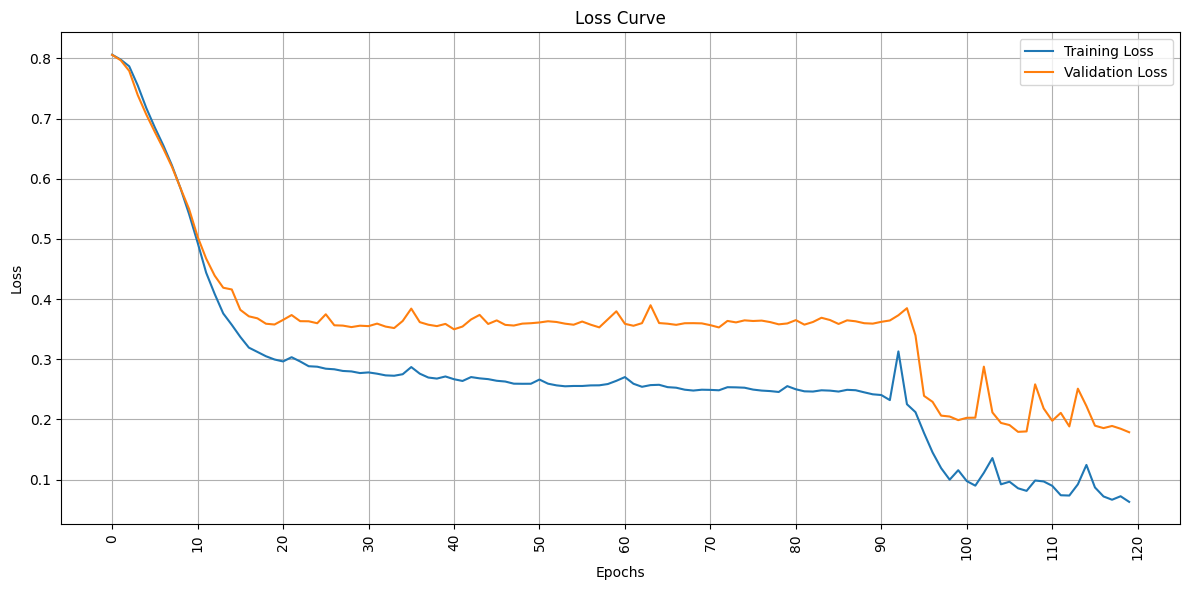

In [47]:
# Save data
# SaveTrainAndValidLosses("train_and_losses_500_epochs.csv")


plt.figure(figsize=(12, 6))  # plot plus large

# Tracer les courbes
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')

plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Grille activée
plt.grid(True)

# Ticks tous les 10 epochs
num_epochs = len(train_losses)
plt.xticks(range(0, num_epochs + 1, 10), rotation=90)  # valeurs horizontales

plt.tight_layout()  # évite que le texte soit coupé
plt.show()


## Load and test the "best" model

In [48]:
model.load_state_dict(torch.load(model_weights_path))

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


<All keys matched successfully>

Image shape: torch.Size([1, 1, 256, 256])


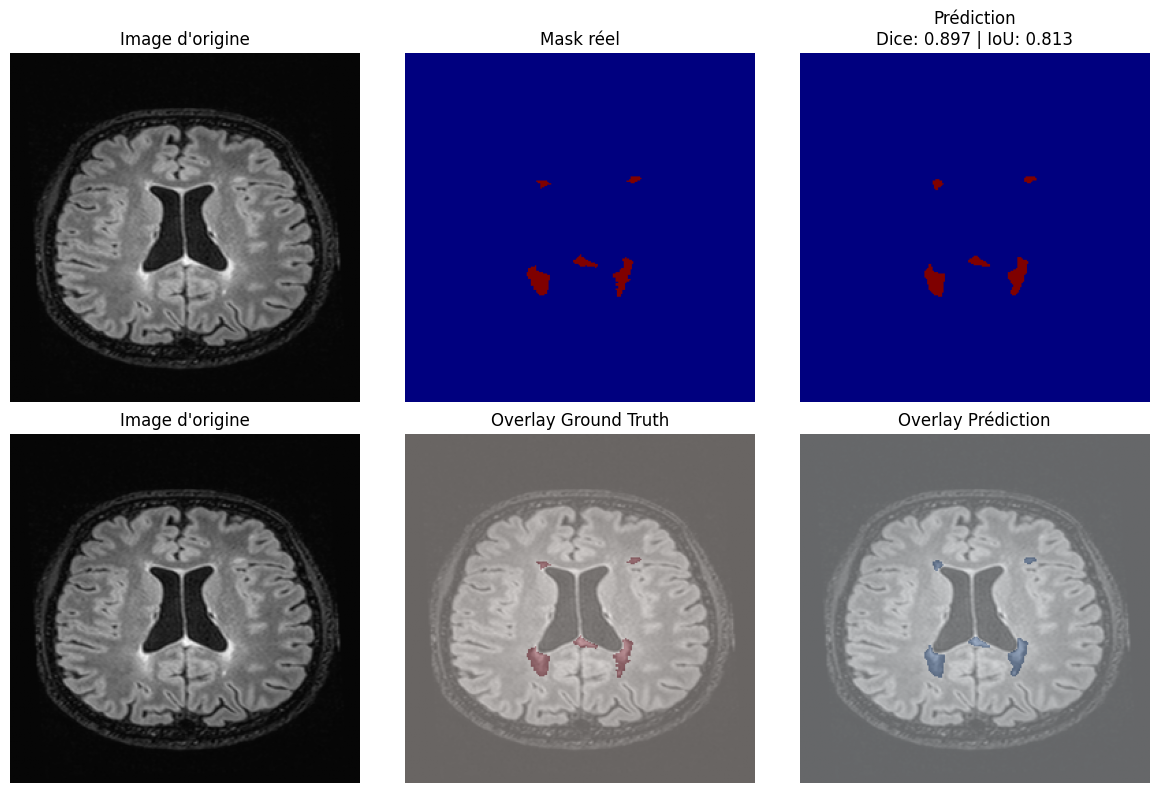

✅ Dice (MONAI) : 0.897
✅ IoU  (MONAI) : 0.813
✅ Dice (NumPy) : 0.897
✅ IoU  (NumPy) : 0.813


In [51]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from monai.networks.nets import UNet
from sklearn.metrics import jaccard_score
from monai.metrics import DiceMetric, MeanIoU

# --- METRICS MONAI ---
dice_metric = DiceMetric(include_background=False, reduction="mean")
iou_metric = MeanIoU(include_background=False)

# --- METRICS numpy ---
def dice_score(pred, label):
    pred = pred.astype(np.bool_)
    label = label.astype(np.bool_)
    intersection = np.logical_and(pred, label).sum()
    return 2. * intersection / (pred.sum() + label.sum() + 1e-8)

def iou_score(pred, label):
    pred = pred.astype(np.bool_)
    label = label.astype(np.bool_)
    intersection = np.logical_and(pred, label).sum()
    union = np.logical_or(pred, label).sum()
    return intersection / (union + 1e-8)

# --- FONCTION D'ÉVALUATION ---
def evaluate_model_on_batch(model, dataloader, device):
    model = model.to(device)
    model.eval()

    dice_metric.reset()
    iou_metric.reset()

    batch_data = next(iter(dataloader))  # prend un batch

    with torch.no_grad():
        images, labels, names = batch_data  # attention ici : dataset retourne aussi les noms !
        images = images.to(device)
        labels = labels.to(device)

        # prendre seulement la première image du batch
        image = images[0].unsqueeze(0)  # [1, 1, H, W]
        label = labels[0].unsqueeze(0)  # [1, 1, H, W]

        print("Image shape:", image.shape)

        preds = model(image)

        # Appliquer sigmoid + threshold
        preds = torch.sigmoid(preds)
        preds = (preds > 0.5).float()

        # Calcul MONAI metrics
        dice_metric(preds, label)
        iou_metric(preds, label)
        dice_metric_result = dice_metric.aggregate().item()
        iou_metric_result = iou_metric.aggregate().item()

        # --- Conversion numpy pour affichage ---
        image_np = image.squeeze().detach().cpu().numpy()
        label_np = label.squeeze().detach().cpu().numpy()
        preds_np = preds.squeeze().detach().cpu().numpy()

        # Normaliser l'image [-1,1] → [0,1]
        image_np = (image_np + 1) / 2.0

        # Calcul numpy metrics
        dice = dice_score(preds_np, label_np)
        iou = iou_score(preds_np, label_np)

    # --- AFFICHAGE ---
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))

    axes[0, 0].imshow(image_np, cmap="gray")
    axes[0, 0].set_title("Image d'origine")
    axes[0, 0].axis("off")

    axes[0, 1].imshow(label_np, cmap="jet")
    axes[0, 1].set_title("Mask réel")
    axes[0, 1].axis("off")

    axes[0, 2].imshow(preds_np, cmap="jet")
    axes[0, 2].set_title(f"Prédiction\nDice: {dice:.3f} | IoU: {iou:.3f}")
    axes[0, 2].axis("off")

    axes[1, 0].imshow(image_np, cmap="gray")
    axes[1, 0].set_title("Image d'origine")
    axes[1, 0].axis("off")

    axes[1, 1].imshow(image_np, cmap="gray")
    axes[1, 1].imshow(label_np, cmap="Reds", alpha=0.4)
    axes[1, 1].set_title("Overlay Ground Truth")
    axes[1, 1].axis("off")

    axes[1, 2].imshow(image_np, cmap="gray")
    axes[1, 2].imshow(preds_np, cmap="Blues", alpha=0.4)
    axes[1, 2].set_title("Overlay Prédiction")
    axes[1, 2].axis("off")

    plt.tight_layout()
    plt.show()

    print(f"✅ Dice (MONAI) : {dice_metric_result:.3f}")
    print(f"✅ IoU  (MONAI) : {iou_metric_result:.3f}")
    print(f"✅ Dice (NumPy) : {dice:.3f}")
    print(f"✅ IoU  (NumPy) : {iou:.3f}")

# --- UTILISATION ---
# Exemple :
# model = UNet(...)  # Ton modèle déjà chargé
# test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=1)

evaluate_model_on_batch(model, test_dataloader, device)
